In [ ]:
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from deepjr.jr_inv_lstm_model import JRInvDataLoader

# Set parameters
path = "./deepjr_training_data"
estim_params = ('A_e', 'A_i', 'b_e', 'b_i', 'a_1', 'a_2', 'a_3', 'a_4')
nb_sims = 1000
noise_fact = 1  # Adjust as needed
output_dir = "./jr_transformer_output"

# Initialize Data Loader
data_loader = JRInvDataLoader(nb_sims=nb_sims, path=path, estim_params=estim_params, noise_fact=noise_fact)
data_loader.prepare_data()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import xarray as xr
import seaborn as sns
from pathlib import Path
from matplotlib.ticker import FuncFormatter, MaxNLocator
from deepjr.simulation import jr_typical_param, JRSimulator, EventRelatedExp

# ============================================================
# 1. SETUP: DEFAULT PARAMETERS & SIMULATION SETTINGS
# ============================================================
default_params = dict(jr_typical_param)
channel_of_interest = "O2"
fontsize = 22
nb_sims = 200     # Number of simulations per sensitivity analysis
noise_fact = 0.1      # Adjust as needed

# LaTeX labels for display (subscripts)
latex_labels = {
    'A_e': r'$A_{e}$',
    'A_i': r'$A_{i}$',
    'b_e': r'$b_{e}$',
    'b_i': r'$b_{i}$',
    'a_1': r'$a_{1}$',
    'a_2': r'$a_{2}$',
    'a_3': r'$a_{3}$',
    'a_4': r'$a_{4}$'
}

# ============================================================
# 2. FUNCTION: RUN SENSITIVITY FOR ONE PARAMETER
# ============================================================
def run_sensitivity_for_param(param, default_params, nb_sims, noise_fact):
    """
    For the given parameter, vary its value from 0.5*default to 1.5*default in nb_sims steps,
    while keeping all other parameters at their default values.
    Returns:
      - evoked_list: a list of MNE Evoked objects (one per simulation)
      - param_vals: a list of the corresponding parameter values
    """
    default_val = default_params[param]
    print(default_params)
    sim_values = np.linspace(0.5 * default_val, 1.5 * default_val, nb_sims)
    evoked_list = []
    param_vals = []
    print(f"Running sensitivity analysis for {param} ...")
    for val in sim_values:
        new_params = default_params.copy()
        new_params[param] = val

        print(new_params)
        
        # Reinitialize the simulator for a fresh state.
        jr_sim = JRSimulator()
        er_exp = EventRelatedExp(jr_sim.info)
        
        jr_sim.run_simulation(er_exp, new_params, jr_noise_sd=0.0)
        jr_sim.generate_raw(seed=0, noise_fact=noise_fact)
        jr_sim.generate_evoked(er_exp)
        evoked = jr_sim.evoked

        if evoked is None:
            print(f"Warning: Simulation for {param} = {val:.3f} returned no evoked response; skipping.")
            continue
    
        evoked_list.append(evoked)
        param_vals.append(val)

    return evoked_list, param_vals
    

# ============================================================
# 3. FUNCTION: SAVE SENSITIVITY DATA FOR ONE PARAMETER
# ============================================================
def save_sensitivity_data_for_param(param, default_params, nb_sims, noise_fact, channel_of_interest):
    # Run simulations varying the current parameter.
    evoked_list, param_vals = run_sensitivity_for_param(param, default_params, nb_sims, noise_fact)
    if len(evoked_list) == 0:
        print(f"No valid evoked responses for {param}.")
        return None
    
    # Assume all evoked objects share the same time vector.
    times = evoked_list[0].times
    
    # Extract the ERP time series for the chosen channel.
    channel_data = []
    for ev in evoked_list:
        idx = ev.ch_names.index(channel_of_interest)
        channel_data.append(ev.data[idx, :])
    
    # Create an xarray DataArray with dimensions "param_val" and "time".
    da = xr.DataArray(np.array(channel_data),
                      coords={'param_val': param_vals, 'time': times},
                      dims=['param_val', 'time'])
    
    # Compute overall mean ERP (across simulations for this parameter).
    overall_mean_da = da.mean(dim='param_val')
    diff = da - overall_mean_da
    relative_error = np.log10(((diff / overall_mean_da).clip(min=1e-12)) ** 2)
    absolute_error = diff ** 2
    
    # Create an xarray Dataset with the results.
    ds_param = xr.Dataset({
        'ERP': da,
        'relative_error': relative_error,
        'absolute_error': absolute_error
    })
    
    return ds_param



In [ ]:
# ============================================================
# 4. LOOP OVER PARAMETERS (ALL) AND SAVE RESULTS
# ============================================================
# Define the parameters you wish to analyze.
params_to_vary = ('A_e', 'A_i', 'b_e', 'b_i', 'a_1', 'a_2', 'a_3', 'a_4')

# We'll store the sensitivity datasets in a dictionary.
sensitivity_results = {}

for param in params_to_vary:
    ds_param = save_sensitivity_data_for_param(param, default_params, nb_sims, noise_fact, channel_of_interest)
    if ds_param is not None:
        sensitivity_results[param] = ds_param
        # Save each parameter's sensitivity data to a netCDF file.
        filename = f"sensitivity_{nb_sims}_{param}.nc"
        ds_param.to_netcdf(filename)
        print(f"Saved sensitivity data for {param} to {filename}.")

# Next we can merge all results into one xarray Dataset for plotting.
# Note: Merging may require aligning coordinates if the 'param_val' ranges differ.


/Users/deepatilwani/Documents/Phd_projects/DCM/.venv/lib/python3.12/site-packages/xarray/backends/file_manager.py:234: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  file.close()


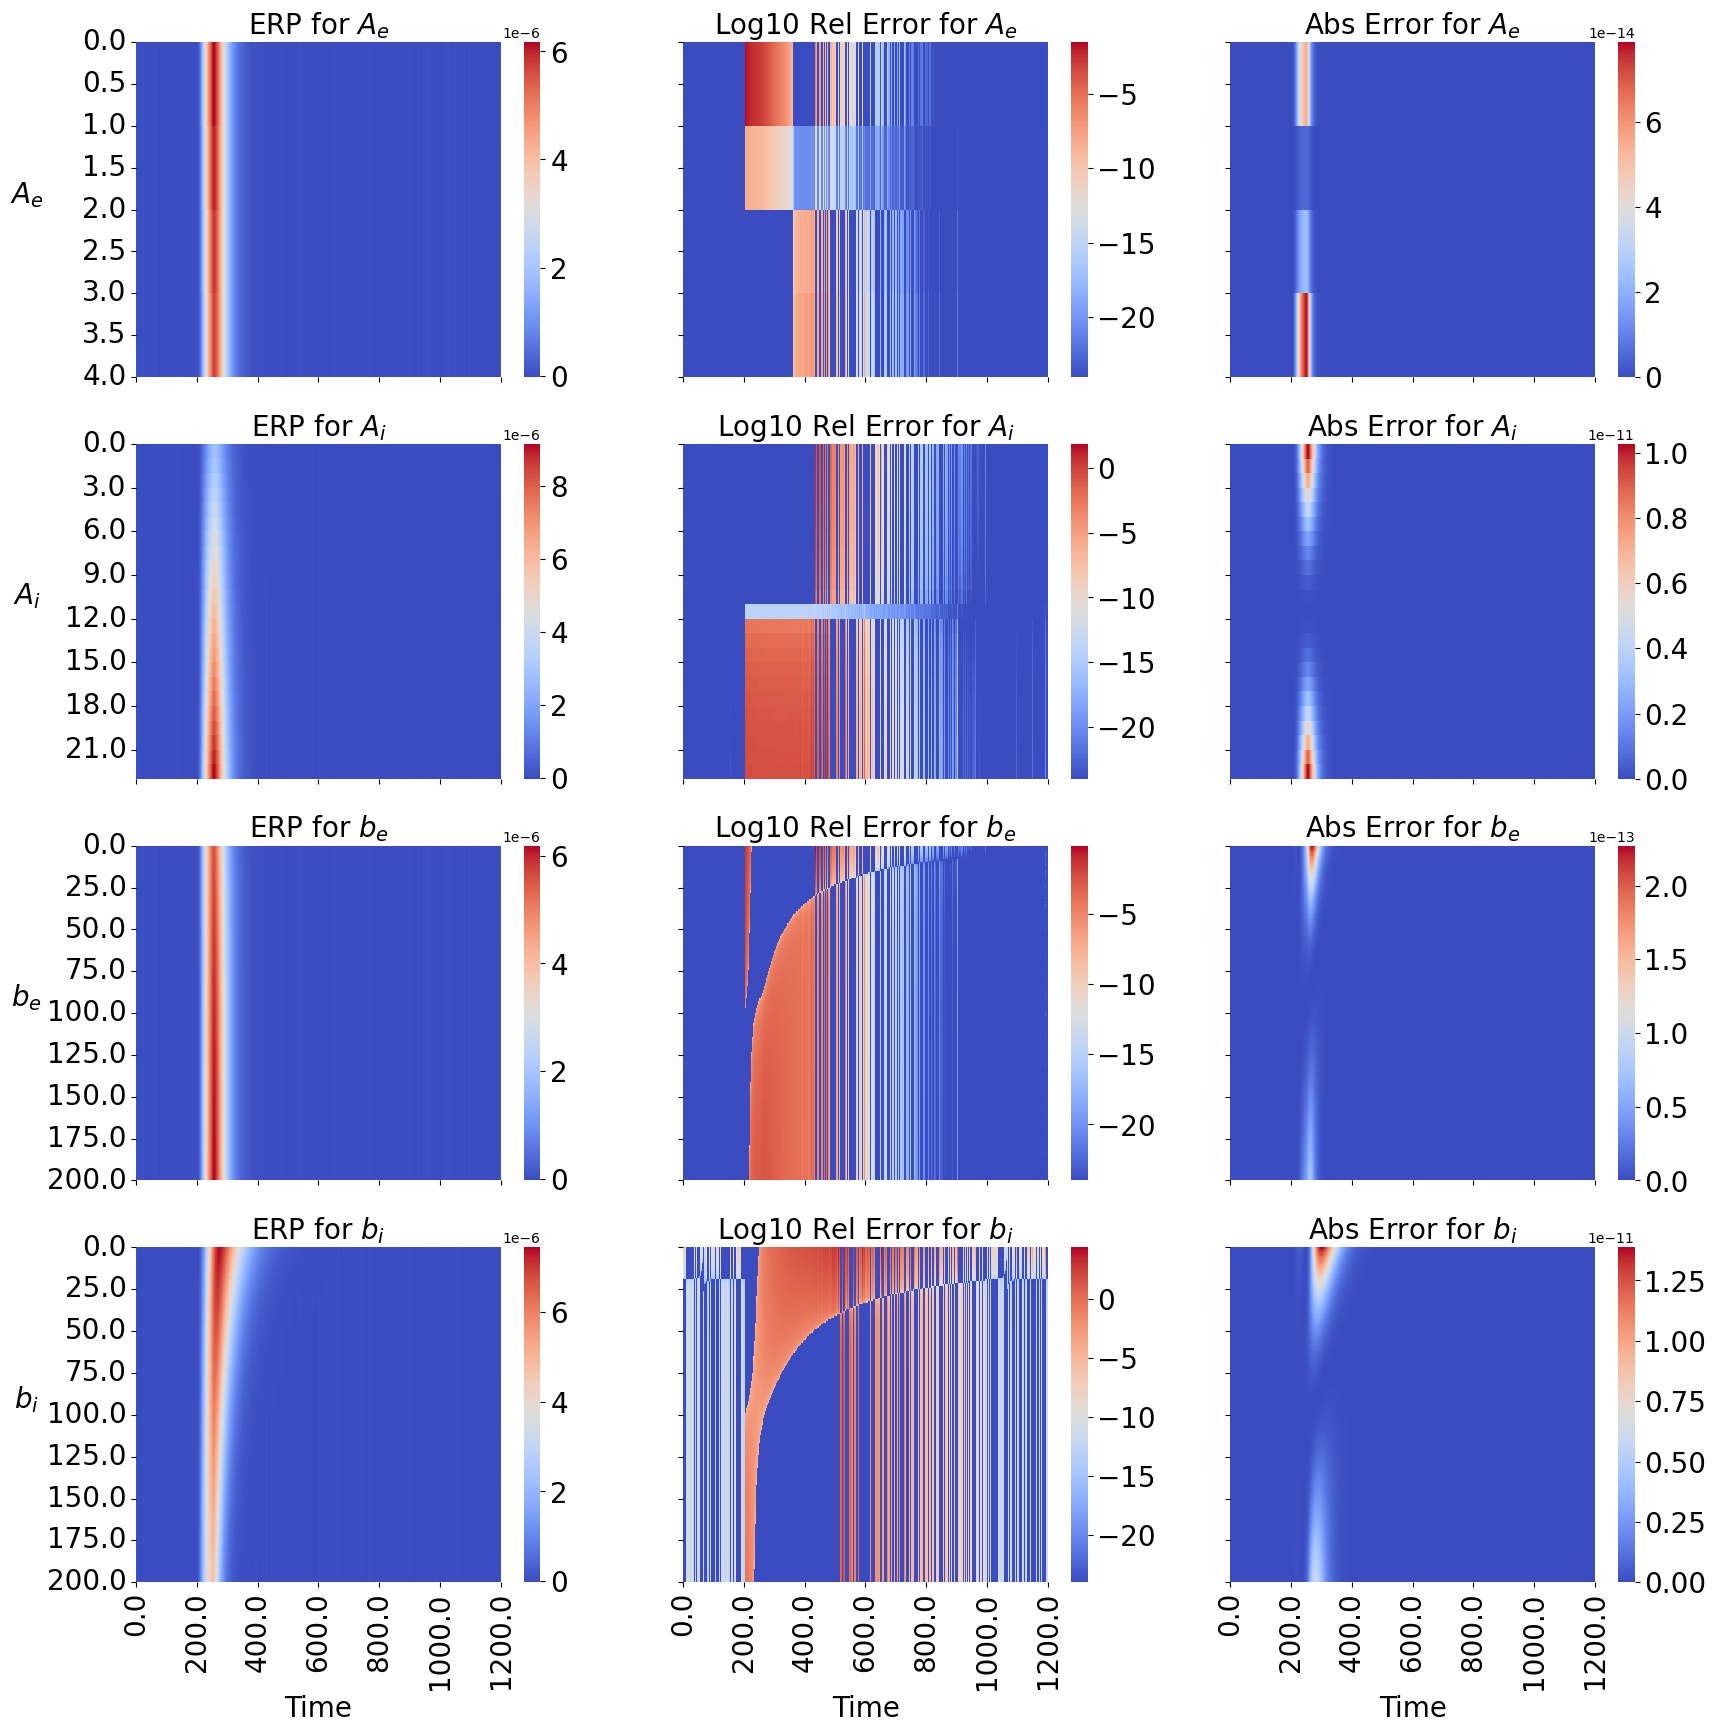

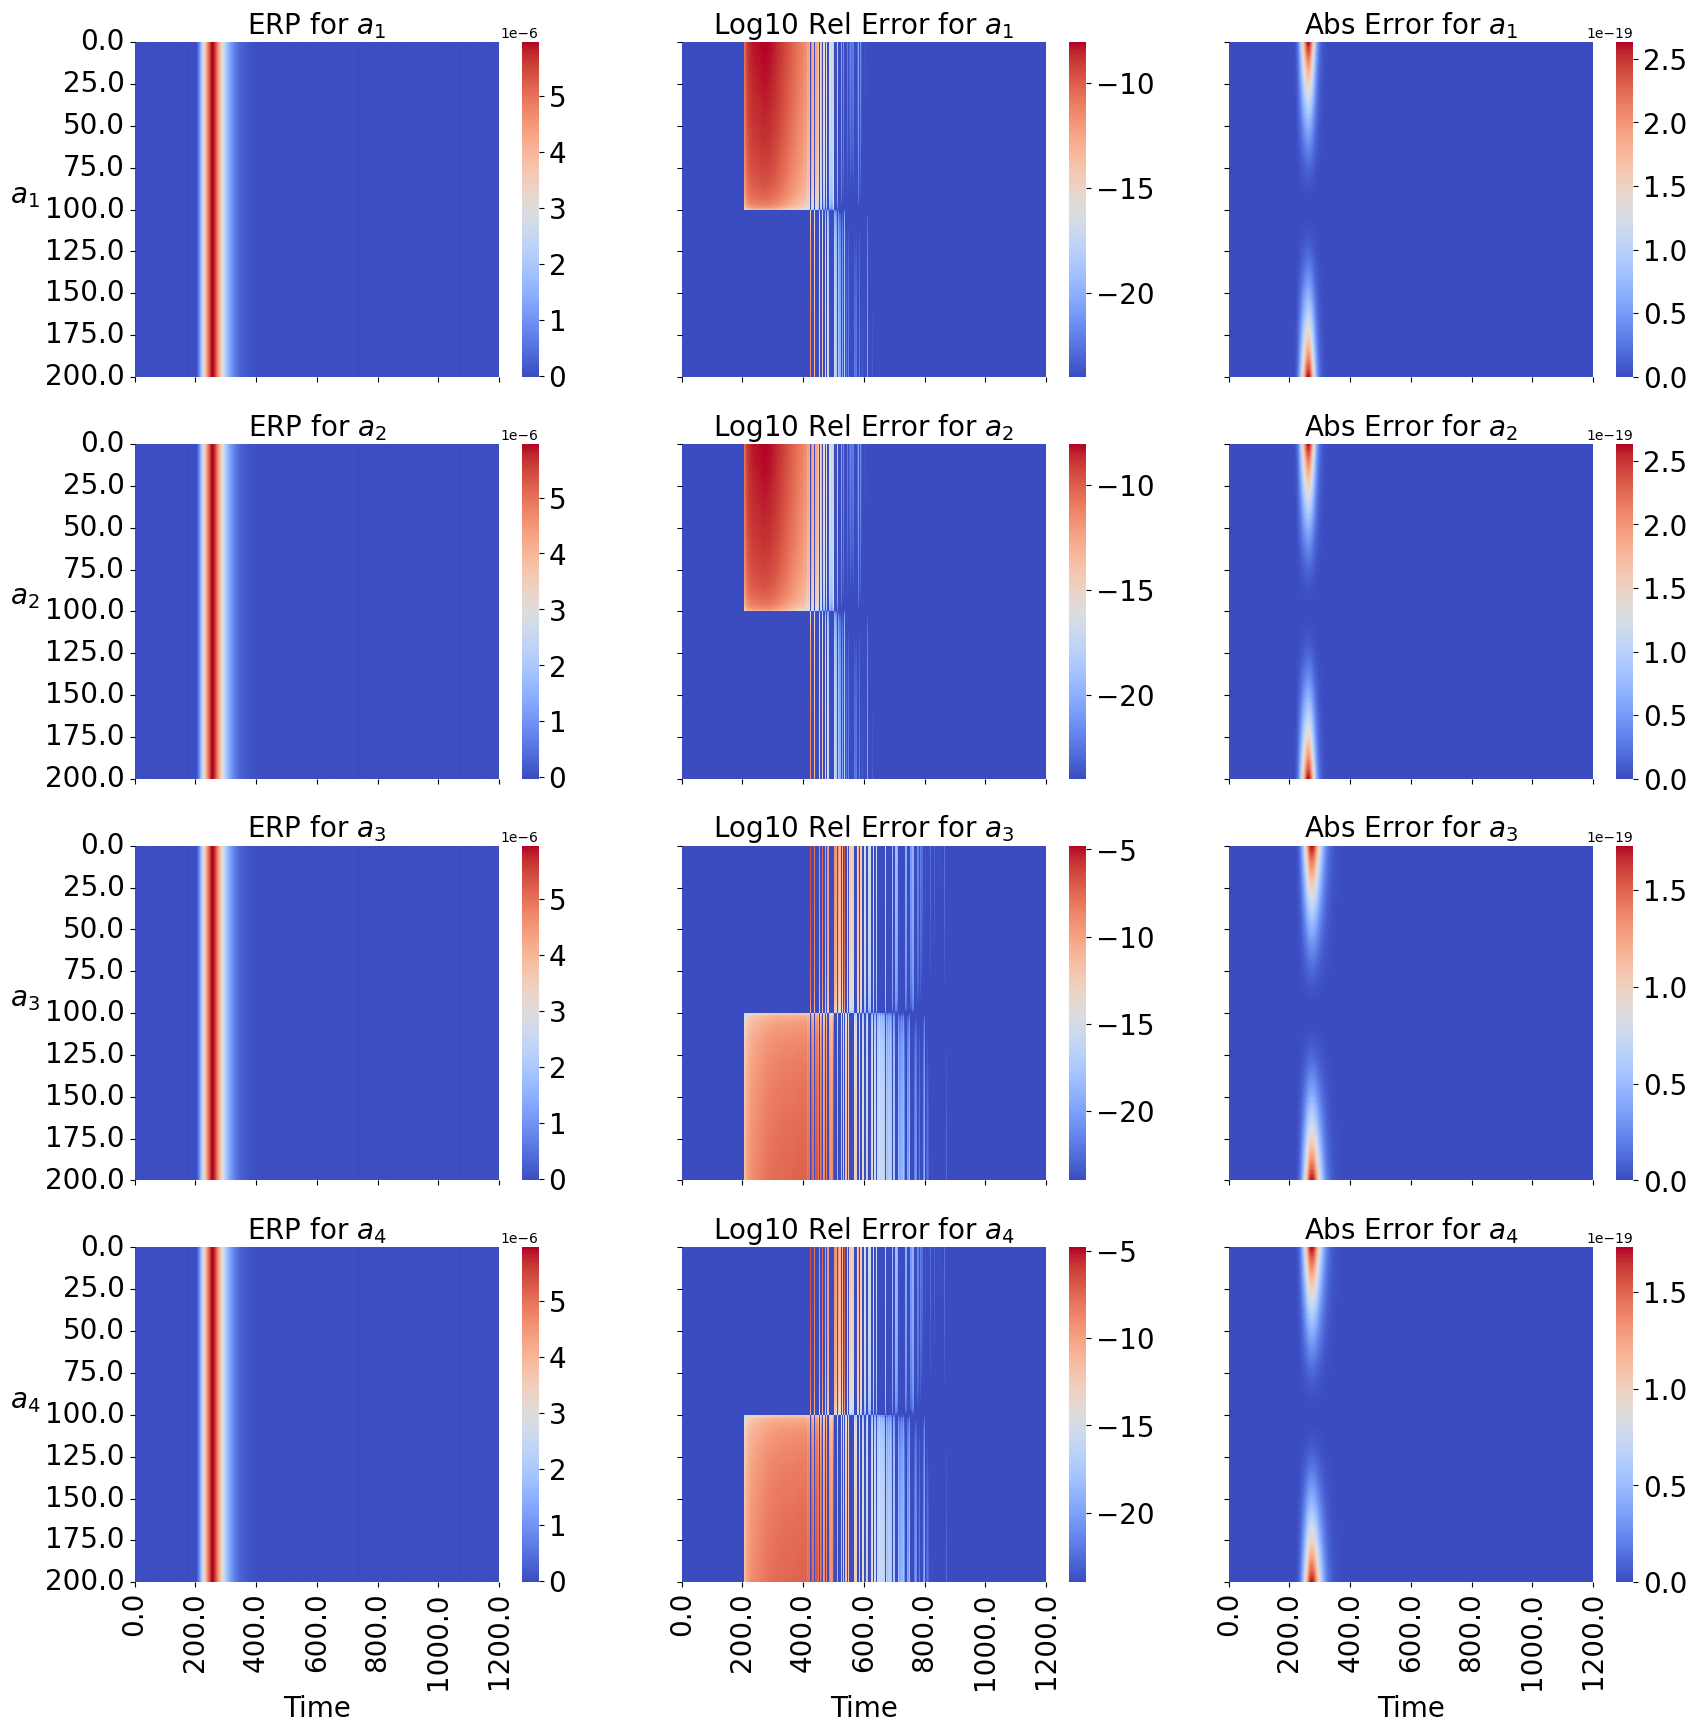

In [12]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter, MaxNLocator

group1 = ('A_e', 'A_i', 'b_e', 'b_i')
group2 = ('a_1', 'a_2', 'a_3', 'a_4')

latex_labels = {
    'A_e': r'$A_{e}$',
    'A_i': r'$A_{i}$',
    'b_e': r'$b_{e}$',
    'b_i': r'$b_{i}$',
    'a_1': r'$a_{1}$',
    'a_2': r'$a_{2}$',
    'a_3': r'$a_{3}$',
    'a_4': r'$a_{4}$'
}

fontsize = 20

def plot_group_sensitivity(param_group, filename, nb_sims):
    n_params = len(param_group)
    fig, axes = plt.subplots(n_params, 3, figsize=(20, 5 * n_params),
                             sharex='col', sharey='row')
    
    # Make sure axes is 2D even if n_params == 1
    if n_params == 1:
        axes = axes[None, :]
    
    formatter = FuncFormatter(lambda x, pos: f"{x:.1f}")

    def plot_heatmap(dataarray, ax, title, param):
        df = dataarray.to_dataframe().reset_index()
        if "param_val" not in df.columns:
            print(f"Data for {param} has no 'param_val'. Columns: {df.columns}")
            return

        df["time"] = df["time"].round(4)
        df["param_val"] = df["param_val"].round(3)
        
        hm_data = df.pivot_table(index="param_val", columns="time",
                                 values="value", aggfunc="mean")
        
        hm = sns.heatmap(hm_data, ax=ax, cmap="coolwarm", cbar=True)
        
        # Remove Seaborn's default y-label
        ax.set_ylabel("") ## for not printing param_val in middle of plots
        
        cbar = hm.collections[0].colorbar
        cbar.ax.tick_params(labelsize=fontsize)

        ax.set_title(title, fontsize=fontsize)
        ax.xaxis.set_major_formatter(formatter)
        ax.yaxis.set_major_formatter(formatter)
        ax.xaxis.set_major_locator(MaxNLocator(nbins=8))
        ax.yaxis.set_major_locator(MaxNLocator(nbins=8))
        ax.tick_params(axis='x', labelsize=fontsize)
        ax.tick_params(axis='y', labelsize=fontsize)

    for i, param in enumerate(param_group):
        nc_file = f"sensitivity_{nb_sims}_{param}.nc"
        try:
            ds_param = xr.open_dataset(nc_file)
        except Exception as e:
            print(f"Error loading {nc_file}: {e}")
            continue
        
        required_vars = ("ERP", "relative_error", "absolute_error")
        missing_vars = [v for v in required_vars if v not in ds_param]
        if missing_vars:
            print(f"Dataset {nc_file} is missing required variables: {missing_vars}")
            continue
        
        da_erp = ds_param["ERP"].rename("value")
        da_rel = ds_param["relative_error"].rename("value")
        da_abs = ds_param["absolute_error"].rename("value")
        
        plot_heatmap(da_erp, axes[i, 0], f"ERP for {latex_labels.get(param, param)}", param)
        plot_heatmap(da_rel, axes[i, 1], f"Log10 Rel Error for {latex_labels.get(param, param)}", param)
        plot_heatmap(da_abs, axes[i, 2], f"Abs Error for {latex_labels.get(param, param)}", param)
        
        # Make the y-label read horizontally (left to right)
        axes[i, 0].set_ylabel(
            latex_labels.get(param, param),
            fontsize=fontsize,
            rotation=0  # Makes the y-axis label horizontal
        )

        # Ensure y-tick labels are horizontal
        axes[i, 0].tick_params(axis='y', labelrotation=0)
        # Shift the label if needed so it's visible
        axes[i, 0].yaxis.set_label_coords(-0.3, 0.5)
        
        # Only label the x-axis on the last row
        if i < n_params - 1:
            for j in range(3):
                axes[i, j].set_xlabel("")
        else:
            for j in range(3):
                axes[i, j].set_xlabel("Time", fontsize=fontsize)
                axes[i, j].tick_params(axis='x', labelsize=fontsize)

    fig.savefig(filename, dpi=300)
    plt.show()


# Example usage:
nb_sims = 200
plot_group_sensitivity(group1, "sensitivity_group1.png", nb_sims)
plot_group_sensitivity(group2, "sensitivity_group2.png", nb_sims)
